# Implementing a reparameterized Beta sampler
@fritzo 2017-11-30

This notebook derives a `standard_beta_grad(x,alpha,beta)` function could be used to compute reparameterized gradients in `torch.distributions.Beta().sample()`. This would replace the current stochastic reparameterized gradient estimator based on `Gamma().sample()`.

In [1]:
import torch
from torch.autograd import Variable
import itertools
import numbers
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
from matplotlib import pyplot
from torch.distributions import Beta, Normal
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha,beta). This is based on the following definition. Let $x\sim Beta(\alpha,\beta)$ be a Beta random variable. The the reparameterized gradient wrt $\alpha$ is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [3]:
def dx_dalpha(x, alpha, beta):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.beta.cdf
    pdf = scipy.stats.beta.pdf
    eps = alpha * 0.02
    d_dalpha = (cdf(x, alpha + eps, beta) - cdf(x, alpha - eps, beta)) / (2 * eps)
    d_dx = pdf(x, alpha, beta)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

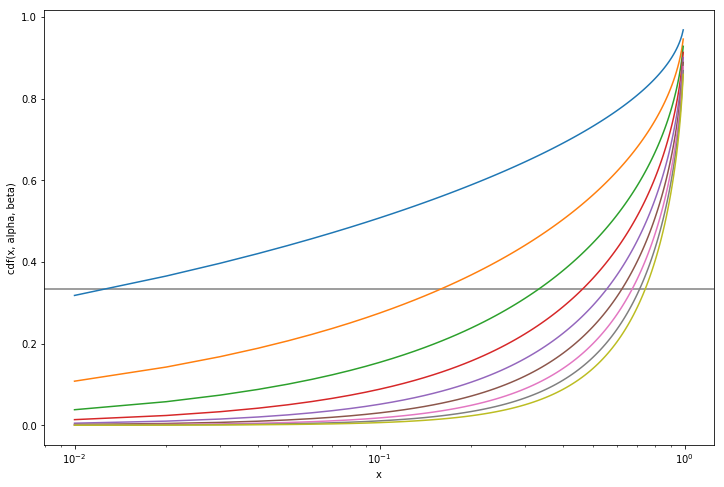

In [4]:
x = np.arange(0, 1, 0.01)
pyplot.figure(figsize=(12,8))
pyplot.axhline(0.333, color='gray')
beta = 0.5
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(x, scipy.stats.beta.cdf(x, alpha, beta))
pyplot.xscale('log')
pyplot.xlabel('x')
pyplot.ylabel('cdf(x, alpha, beta)')
pyplot.show()

In [5]:
digamma = scipy.special.digamma

def dx_dalpha_small(x, alpha, beta):
    return x / alpha * (1.0 / alpha + digamma(alpha) - np.log(x) - digamma(alpha + beta))
def dx_dbeta_small(x, alpha, beta):
    return x / alpha * (digamma(beta) - digamma(alpha + beta))
def dx_dalpha_small_valid(x, alpha, beta):
    return x < 0.002

def dx_dalpha_large(x, alpha, beta):
    return -dx_dbeta_small(1.0 - x, beta, alpha)
def dx_dalpha_large_valid(x, alpha, beta):
    return dx_dalpha_small_valid(1.0 - x, beta, alpha)

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:400: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a, b))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


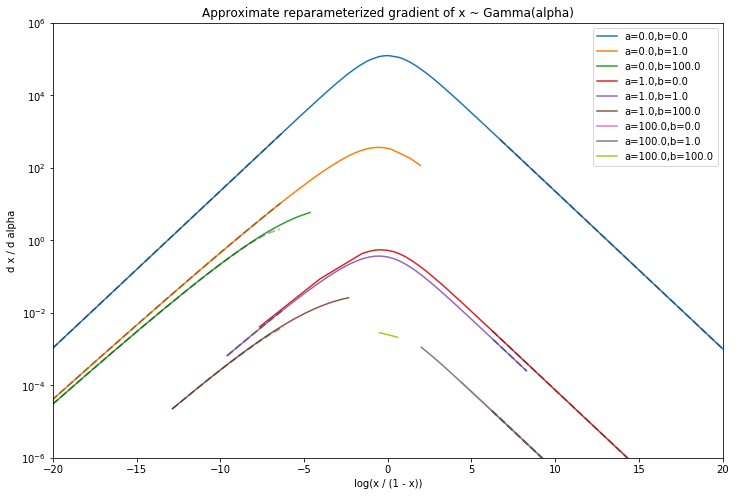

In [6]:
pyplot.figure(figsize=(12, 8))
for alpha, beta in itertools.product([1e-3, 1e0, 1e2], [1e-3, 1e0, 1e2]):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / (1 - x))
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)),
                label='a={:0.1f},b={:0.1f}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-20, 20)
pyplot.ylim(1e-6, 1e6)
pyplot.legend()
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

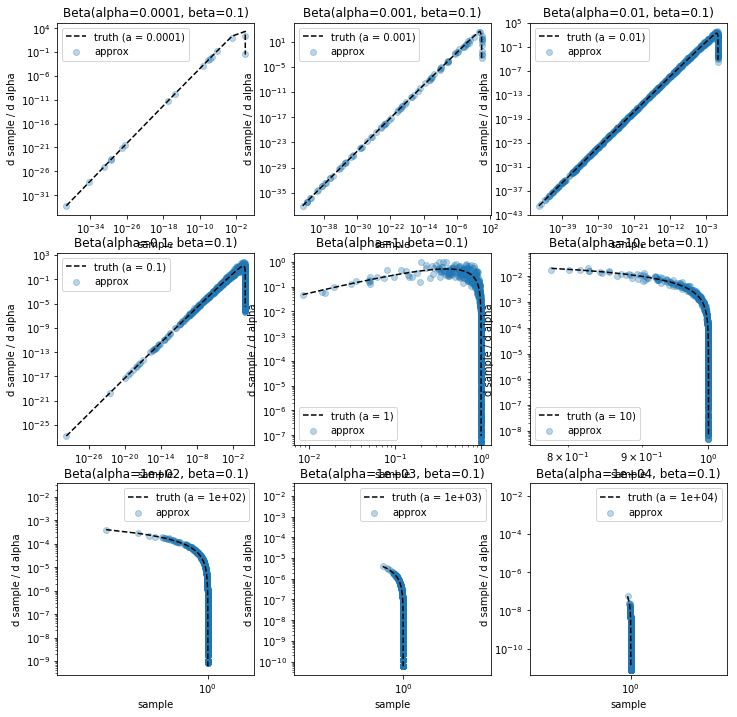

In [7]:
set_seed(0)
alpha = 29
num_samples = 1000
fig, axes = pyplot.subplots(3, 3, figsize=(12,12))
alpha_grid = np.array([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
for ax, alpha in zip(axes.reshape(-1), alpha_grid):
    beta = 0.1
    alphas = Variable(alpha * torch.ones(num_samples), requires_grad=True)
    betas = Variable(beta * torch.ones(alphas.size()))
    x = Beta(alphas, betas).sample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    actual_grad = alphas.grad.data[ind].numpy()
    alphas = alphas.data[ind].numpy()
    ax.scatter(x, actual_grad, alpha=0.3, label='approx')
    ax.plot(x, dx_dalpha(x, alpha, beta), 'k--', label='truth (a = {:0.2g})'.format(alpha))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Beta(alpha={:0.2g}, beta={:0.2g})'.format(alpha, beta))
    ax.set_xlabel('sample')
    ax.set_ylabel('d sample / d alpha')
    ax.legend()
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is. It's actually cheaper than the forward sampler.

In [8]:
n = 10
dist = Beta(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
            Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 1.57 s, sys: 114 ms, total: 1.68 s
Wall time: 1.7 s
---- Backward ----
CPU times: user 1.12 s, sys: 196 ms, total: 1.31 s
Wall time: 1.33 s


Here's a Normal distribution for comparison.

In [9]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
# %time x = dist.sample(requires_grad=True)
# print('---- Backward ----')
# %time x.sum().backward()

---- Forward ----
CPU times: user 439 ms, sys: 50.4 ms, total: 489 ms
Wall time: 491 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha, beta)` that we want to approximate.

Let's approximate using a trivariate rational function of $\log(x/\alpha)$ and $\log(\alpha)$.

In [10]:
def expand_all(*args):
    zero = np.zeros(np.broadcast(*args).shape)
    return tuple(zero + arg for arg in args)

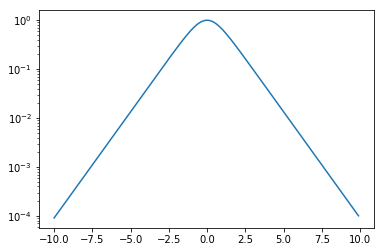

In [11]:
x = np.arange(-10, 10, 0.1)
pyplot.plot(x, 1.0 / np.cosh(x))
pyplot.yscale('log')

In [12]:
K = 15  # number of training parameters
def dx_dalpha_approx(x, alpha, beta, coeff):
    x, alpha, beta = expand_all(x, alpha, beta)
    u = np.log(x / (1.0 - x))
    a = np.log(alpha)
    b = np.log(beta)
    coeff = list(coeff)
    c = coeff.pop
    u0 = c() + c() * a + c() * b + c() * a * b
    # u0 /= 1. + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    # u1 = np.maximum(0.0, 1.0 + c())
    u1 = 0.5 + c() + c() * a + c() * b + c() * a * b
    g0 = c() + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    # g0 /= 1. + c() * a + c() * b + c() * a * a + c() * a * b + c() * b * b
    g1 = np.maximum(0.0, 1.0 + c())
    assert not coeff, len(coeff)
    return g0 * np.cosh((u - u0) * u1) ** (-g1 / u1)

### Constructing training data

In [13]:
np.random.seed(0)
size_train = 5000
LB, UB = 1e-2, 1e0
alpha_train = np.exp(np.random.random(size_train) * (np.log(UB) - np.log(LB)) + np.log(LB))
beta_train = np.exp(np.random.random(size_train) * (np.log(UB) - np.log(LB)) + np.log(LB))
alpha_train.sort()
x_train = scipy.stats.beta.rvs(alpha_train, beta_train)
grad_train = dx_dalpha(x_train, alpha_train, beta_train)

valid = (0.001 < x_train) & (x_train < 0.999)
# valid = valid.nonzero()[0]
alpha_train = alpha_train[valid]
beta_train = beta_train[valid]
x_train = x_train[valid]
grad_train = grad_train[valid]

print('alpha = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    alpha_train[0], alpha_train[1], alpha_train[-2], alpha_train[-1]))
print('x = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    x_train[0], x_train[1], x_train[-2], x_train[-1]))
print('grad = [{:0.5g}, {:0.5g}, ..., {:0.5g}, {:0.5g}]'.format(
    grad_train[0], grad_train[1], grad_train[-2], grad_train[-1]))
print(len(grad_train))

alpha = [0.010003, 0.010096, ..., 0.99668, 0.99983]
x = [0.93461, 0.89886, ..., 0.82646, 0.9959]
grad = [95.719, 189.17, ..., 0.23483, 0.0052174]
1842


We construct a stratified training set to balance the non-asymptotic regions across all $(\alpha,\beta)$ pairs.

In [14]:
np.random.seed(0)
size_train = 5000
LB, UB, grid_size = 1e-3, 1e2, 7
grid = LB * (UB / LB) ** (np.array(range(grid_size)) / (grid_size - 1.0))
alpha_bins, beta_bins, x_bins = [], [], []
bin_size = size_train / len(grid) ** 2
for alpha, beta in itertools.product(grid, grid):
    alpha_train = alpha * np.ones(10 * size_train)
    beta_train = beta * np.ones(10 * size_train)
    x_train = scipy.stats.beta.rvs(alpha_train, beta_train)
    valid = (0.001 < x_train) & (x_train < 0.999)
    valid = valid.nonzero()[0]
    valid = valid[:bin_size]
    if len(valid) < bin_size:
        print('Warning: only {}/{} samples collected for alpha={:0.2g}, beta={:0.2g}'.format(
        len(valid), bin_size, alpha, beta))
    alpha_bins.append(alpha_train[valid])
    beta_bins.append(beta_train[valid])
    x_bins.append(x_train[valid])

alpha_train = np.concatenate(alpha_bins)
beta_train = np.concatenate(beta_bins)
x_train = np.concatenate(x_bins)
grad_train = dx_dalpha(x_train, alpha_train, beta_train)
print('Data size = {}'.format(len(grad_train)))

Data size = 4978


In [15]:
def approx_objective(coeff):
    approx = dx_dalpha_approx(x_train, alpha_train, beta_train, coeff).reshape(-1)
    return 1 - approx / grad_train

In [16]:
coeff0 = np.zeros(K)
coeff = coeff0

In [17]:
soln = scipy.optimize.least_squares(approx_objective, coeff0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coeff = soln.x
print(soln)
print('coeff = {}'.format(list(coeff)))
error = approx_objective(coeff)
print('error = {:0.3g} rms, {:0.3g} max'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max()))

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`ftol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:117: UserWarning: `gtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`gtol`", EPS))


 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])
        cost: 803.68774200752068
         fun: array([ 0.96971941,  0.99995364,  0.99923455, ...,  0.0072934 ,
        0.09537512, -0.01940842])
        grad: array([ -1.46271188e-05,  -1.76912346e-03,  -2.97626213e-04,
         2.87221047e-03,  -1.78511521e-04,   4.83896296e-04,
         7.15037846e-05,  -4.79839860e-04,   1.46301208e-04,
         1.51002113e-04,   2.27391643e-05,   2.23975057e-04,
        -8.14308862e-05,  -3.34572324e-05,   2.65868019e-05])
         jac: array([[ -8.94171074e-02,  -7.00379610e-01,  -7.00379610e-01, ...,
          1.91572018e-01,   1.91572018e-01,  -2.77328864e-02],
       [ -1.82017684e-05,  -1.07219815e-03,  -1.07219815e-03, ...,
         -1.39191747e-04,  -1.39191747e-04,   2.01463699e-05],
       [ -1.03431940e-03,  -1.77045390e-02,  -1.77045390e-02, ...,
          3.83619219e-03,   3.83619219e-03,  -5.55343926e-04],
       ..., 
       [  2.13

Here's a per-region version that's closer our C implementation:

In [18]:
def dx_dalpha_final(x, alpha, beta):
    result = dx_dalpha_approx(x, alpha, beta, coeff)
    w = dx_dalpha_small_valid(x, alpha, beta)
    result[w] = dx_dalpha_small(x[w], alpha, beta)
    w = dx_dalpha_large_valid(x, alpha, beta)
    result[w] = dx_dalpha_large(x[w], alpha, beta)
    return result

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


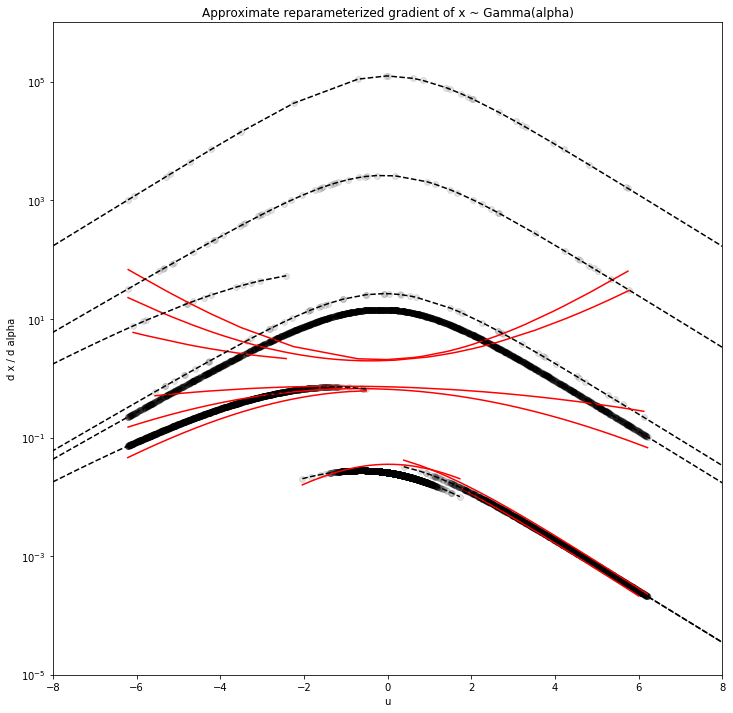

In [19]:
pyplot.figure(figsize=(12, 12))
ones = np.ones(5000)
for alpha, beta in itertools.product([1e-3, 1e-1, 1e1], [1e-3, 1e-1, 1e1]):
    x = scipy.stats.beta.rvs(ones * alpha, ones * beta)
    x.sort()
    u = np.log(x / (1 - x))
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), 'k--')
    w = ~(dx_dalpha_small_valid(x, alpha, beta) | dx_dalpha_large_valid(x, alpha, beta))
    x, u = x[w], u[w]
    pyplot.scatter(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), color='black', alpha=0.1)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha_final(x, alpha, beta)), 'r-')
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('u')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-8, 8)
pyplot.ylim(1e-5, 1e6)
pyplot.legend()
pyplot.show()

Finally, let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [20]:
print('static const double coef_uv[3][8] = {')
for row in coeff.reshape(3, 8):
    print('  {' + ', '.join(map('{:0.8g}'.format, row)) +'},')
print('};')

static const double coef_uv[3][8] = {


ValueError: cannot reshape array of size 15 into shape (3,8)